# Options 2: The Binomial Option Pricing Model

This notebook implements the binomial option pricing model for European and American style options.

You may also consider the [FinancialDerivatives.jl](https://github.com/JuliaQuant/FinancialDerivatives.jl) package for a more ambitious pricing models (not used here).

## Load Packages and Extra Functions

The [OffsetArrays.jl](https://github.com/JuliaArrays/OffsetArrays.jl) package allows flexible indexing of an array. In particular, it allows us to refer to the first element of a vector as element 0. This is useful in order to stick close to lecture notes on binomial trees where period $0$ is the starting point and we take $n$ time steps.

In [1]:
using Printf, OffsetArrays

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :png)

# The Binomial Model for *One* Time Step

In a binomial model the price of the underlying asset can change from $S$ today to either $Su$ or $Sd$ in the next period (which is $h$ years from now).

Let $f_u$ and $f_d$ be the values of the derivative in the up- and down states (next period). Then, the value today is

$f  =e^{-yh}\left[  pf_{u}+\left(  1-p\right)  f_{d}\right] \: \text{ with } \: p=\frac{e^{yh}-d}{u-d}$

For a call option that expires, the payoffs in the two states are

$
f_u = \max(Su-K,0)
$

$
f_d = \max(Sd-K,0)
$

In [3]:
(S,K,y) = (10,10,0)             #underlying price today, strike pricem interest rate
(u,d,h) = (1.1,0.95,1/12)       #up move, down move, length of time period 

fu = max(S*u-K,0)               #value of call option in up node 
fd = max(S*d-K,0)               #in down node

p = (exp(y*h)-d)/(u-d)
C = exp(-y*h)*(p*fu+(1-p)*fd)

printblue("Pricing of a call option with strike $K, one time step:\n")
printmat([fu,fd,p,C],rowNames=["Payoff 'up'","Payoff 'down'","p","call price now"])

Pricing of a call option with strike 10, one time step:

Payoff 'up'        1.000
Payoff 'down'      0.000
p                  0.333
call price now     0.333



# A CRR Tree for *Many* (Short) Time Steps

The CRR approach to construct $(u,d)$ for a small time step of length $h$ is 

$u=e^{\sigma\sqrt{h}} \: \text{ and }\: d=e^{-\sigma\sqrt{h}}$,

where $\sigma$ is the annualized standard deviation of the underlying. Notice that $p$ depends on the choice of $(u,d)$ 

$
p=\frac{e^{yh}-d}{u-d}.
$

In [4]:
m = 0.5                 #time to expiration (in years)
y = 0.05                #interest rate (annualized) 
σ = 0.2                 #annualized std of underlying asset

n = 50                  #number of time steps of size h
h = m/n                 #time step size (in years)

u = exp(σ*sqrt(h))
d = exp(-σ*sqrt(h))
p = (exp(y*h) - d)/(u-d)  #p depends on u and d

printblue("CRR parameters in tree when m=$m, y=$y, σ=$σ and n=$n:\n")
xx = [h,u,d,p,exp(y*h)]
printmat(xx,rowNames=["h","u","d","p","exp(yh)"])

printblue("Checking if u > exp(y*h) > d: ", u > exp(y*h) > d)

CRR parameters in tree when m=0.5, y=0.05, σ=0.2 and n=50:

h           0.010
u           1.020
d           0.980
p           0.508
exp(yh)     1.001

Checking if u > exp(y*h) > d: true


## Build a Tree for the Underlying Asset

The next cell illustrates how we can create a vector of vectors (of different lengths). In this example, ```x[0]``` is a vector ```[0]```, while ```x[1]``` is a vector ```[1,1]```, etc.

In [5]:
x = [ones(i+1)*i for i = 0:2]      #vector or vectors (of different lengths)
x = OffsetArray(x,0:2)             #convert so the indices are 0:2

printblue("Illustrating a vector of vectors:\n")
for i = 0:2
    printblue("i=$i:")
    printmat(x[i])
end

Illustrating a vector of vectors:

i=0:
     0.000

i=1:
     1.000
     1.000

i=2:
     2.000
     2.000
     2.000



We create a tree by starting at the current spot price $S$. The future nodes are then created by multiplying by $u$ or $d$

$\text{step 0}: (S)$

$\text{step 1}: (Su,Sd)$

$\text{step 2}: (Suu,Sud,Sdd)$ (since $Sud=Sdu$)

...

For step 2, the code in the next cell creates the vector $(Suu,Sud,Sdd)$ by first multiplying the step 1 vector by the up factor ($u(Su,Sd)$) and then attaching (as the last element) the last element of the step 1 vector times the down factor ($dSd$). 

### A Remark on the Code
- `STree[0]` corresponds to time step 0, and `STree[n]` to time step $n$, since we define `STree` as `OffsetArray(x,0:n)` where `x` is a traditional vector (of vectors) where the first index is 1.

In [6]:
"""
    BuildSTree(S,n,u,d)

Build binomial tree, starting at `S` and having `n` steps with up move `u` and down move `d`

# Output
- `STree:: Vector or vectors`: each (sub-)vector is for a time step. `STree[0] = [S]` and `STree[n]` is for time period n.

"""
function BuildSTree(S,n,u,d)
    STree = [fill(NaN,i) for i = 1:n+1]  #vector of vectors (of different lengths)
    STree = OffsetArray(STree,0:n)       #convert so the indices are 0:n
    STree[0][1] = S                      #step 0 is in STree[0], element 1 
    for i = 1:n                          #move forward in time
        STree[i][1:end-1] = u*STree[i-1]   #up move from STree[i-1][1:end]
        STree[i][end] = d*STree[i-1][end]  #down move from STree[i-1][end] 
    end
    return STree
end

BuildSTree

## Showing the Tree for the Underlying Asset

The next few cells illustrate how these nodes are put into a vector of vectors and then show the entire tree.

### A Remark On the Code

The plots below loops over the different elements in `STree` to plot the scatter. It is also possible to create the plots by something like the following
```
Step = [ones(i+1)*i for i = 0:n]      #vector or vectors (of different lengths)
Step = OffsetArray(Step,0:n)             #convert so the indices are 0:2
p1 = scatter( vcat(Step...),vcat(STree...) )
```

In [7]:
S = 42.0                             #current price of underlying asset

STree = BuildSTree(S,n,u,d)
printblue("printing the first 3 time steps in the tree\n")
for i = 0:2
    printblue("i=$i:")
    printmat(STree[i])
end

printing the first 3 time steps in the tree

i=0:
    42.000

i=1:
    42.848
    41.168

i=2:
    43.714
    42.000
    40.353



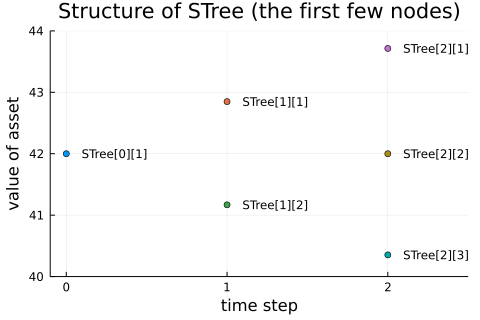

In [8]:
p1 = plot( legend = false,
           xlim = (-0.1,2.5),
           ylim = (40,44),
           xticks = 0:2,
           title = "Structure of STree (the first few nodes)",
           xlabel = "time step",
           ylabel = "value of asset" )

for i = 0:2, j = 1:length(STree[i])
    scatter!( [i],[STree[i][j]],             #[] to make a 1-element vector
              annotation = (i+0.1,STree[i][j],text("STree[$i][$j]",8,:left)) )
end
display(p1)           #needed since plot() does not have data points to plot

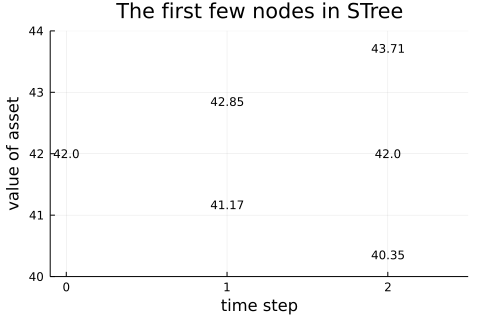

In [9]:
p1 = plot( legend = false,
           xlim = (-0.1,2.5),
           ylim = (40,44),
           xticks = 0:2,
           title = "The first few nodes in STree",
           xlabel = "time step",
           ylabel = "value of asset" )

for i = 0:2, j = 1:length(STree[i])
    annotate!(i,STree[i][j],text(string(round(STree[i][j],digits=2)),8))
end
display(p1)

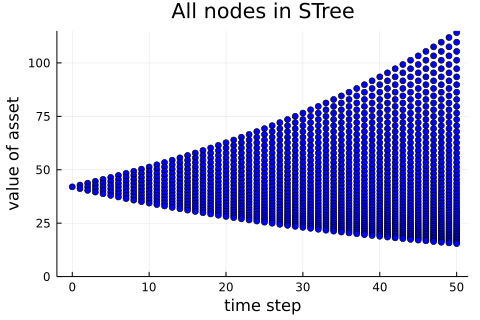

In [10]:
p1 = scatter( [0.0],STree[0],
              markercolor = :blue,
              xlim = (-2,n+1.5),
              ylim = (0,115),
              legend = false,
              title = "All nodes in STree",
              xlabel = "time step",
              ylabel = "value of asset" )

for i = 1:n
    scatter!(fill(i,i+1),STree[i],color=:blue)
end
display(p1)

# Calculating the Option Price

Let $f_{ij}$ be the option price at time step $i$ when the underlying price is $S_{ij}$. (We use $S_{ij}$ as a shorthand notation, to avoid writing things like $Sudd$.) In the code below, $S_{i1}$ is the highest node in time step $i$, $S_{i2}$ is the second highest, etc.

For a European call option, the call price at the last time step $n$ is 
$f_{nj} = \max(0,S_{nj}-K)$. Similarly, the put price is $f_{nj} = \max(0,K-S_{nj})$. 

For all earlier time steps, the value is 

$f_{ij} = e^{-yh}[p f_{i+1,j} + (1-p) f_{i+1,j+1}]$.

### A Remark on the Code
- Inside the function `EuOptionPrice()`, `Value = similar(STree)` is used to create a new vector (of vectors) called `Value` with the same structure as `STree`.

## European Options

In [11]:
"""
    EuOptionPrice(STree,K,y,h,p,isPut=false)

Calculate price of European option from binomial model

# Output
- `Value:: Vector of vectors`: option values at different nodes, same structure as STree

"""
function EuOptionPrice(STree,K,y,h,p,isPut=false)     #price of European option
    Value = similar(STree)                            #tree for derivative, to fill
    n     = length(STree) - 1                         #number of steps in STree
    if isPut
        Value[n] = max.(0,K.-STree[n])            #put, at last time node
    else
        Value[n] = max.(0,STree[n].-K)            #call, at last time node
    end
    for i = n-1:-1:0                                   #move backward in time
        Value[i] = exp(-y*h)*(p*Value[i+1][1:end-1] + (1-p)*Value[i+1][2:end])
    end                                           #p*up + (1-p)*down, discount
    return Value
end

EuOptionPrice

In [12]:
K = 42.0                                  #strike price 

Pₑ = EuOptionPrice(STree,K,y,h,p,true)        #Pₑ[0] is a 1x1 vector with the put price (node 0)
Cₑ = EuOptionPrice(STree,K,y,h,p,false)       #use Pₑ[0][1] or Pₑ[0][]

Cₑ_parity = Pₑ[0][] + S - exp(-m*y)*K              #put-call parity, Pₑ[0][] makes it a scalar

printblue("European option prices at K=$K and S=$S: ")
printmat([Pₑ[0][],Cₑ[0][],Cₑ_parity],rowNames=["put","call","call from parity"])

European option prices at K=42.0 and S=42.0: 
put                  1.844
call                 2.881
call from parity     2.881



## American Options

The option values are calculated as for the European option, except that that the option value is 

$f_{ij} = \max(\text{value if exercised now},\text{continuation value})$

The *continuation value* has the same form as in the European case, and thus assumes that the option has not been exercised before the next period.

The *value of exercising now* is $S_{ij}-K$ for a call and $K-S_{ij}$ for a put.

In [13]:
"""
    AmOptionPrice(STree,K,y,h,p,isPut=false)

Calculate price of American option from binomial model

# Output
- `Value:: Vector of vectors`: option values at different nodes, same structure as STree
- `Exerc::` Vector of vectors`: true if early exercise at the node, same structure as STree

"""
function AmOptionPrice(STree,K,y,h,p,isPut=false)     #price of American option
    Value = similar(STree)                            #tree for derivative, to fill
    n     = length(STree) - 1
    Exerc = similar(Value,BitArray)               #same structure as STree, but BitArrays, empty 
    if isPut
        Value[n] = max.(0,K.-STree[n])            #put, at last time node
    else
        Value[n] = max.(0,STree[n].-K)            #call, at last time node
    end
    Exerc[n] = Value[n] .> 0                      #exercise
    for i = n-1:-1:0                                    #move backward in time
        fa  = exp(-y*h)*(p*Value[i+1][1:end-1] + (1-p)*Value[i+1][2:end])
        if isPut 
            Value[i] = max.(K.-STree[i],fa)         #put
        else
            Value[i] = max.(STree[i].-K,fa)         #call
        end
        Exerc[i] = Value[i] .> fa                   #early exercise
    end
    return Value, Exerc
end

AmOptionPrice

In [14]:
K = 42.0                                  #strike price

(Pₐ,Exerc)  = AmOptionPrice(STree,K,y,h,p,true)
(Cₐ,ExercC) = AmOptionPrice(STree,K,y,h,p,false)

printblue("Put and call prices at K=$K and S=$S: ")
xx = [ Pₐ[0][] Pₑ[0][];Cₐ[0][] Cₑ[0][] ]
printmat(xx,colNames=["American","European"],rowNames=["put","call"])

Put and call prices at K=42.0 and S=42.0: 
      American  European
put      1.950     1.844
call     2.881     2.881



## Plotting the Tree of American Option Values

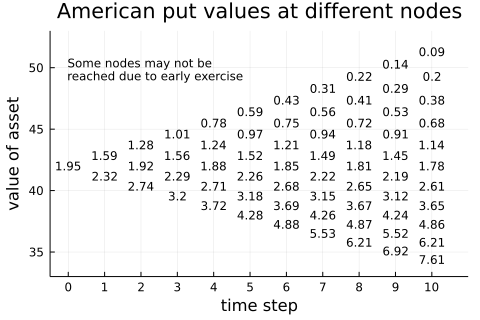

In [15]:
p1 = plot( xlim = (-0.5,11),
           ylim = (33,53), 
           xticks = 0:10,
           legend = false,
           title = "American put values at different nodes",
           xlabel = "time step",
           ylabel = "value of asset",
           annotation = (0,50,text("Some nodes may not be\nreached due to early exercise",8,:left)) )

for i = 0:10, j = 1:length(STree[i])
    annotate!(i,STree[i][j],text(string(round(Pₐ[i][j],digits=2)),8))
end
display(p1)

## Plotting where Exercise Happens

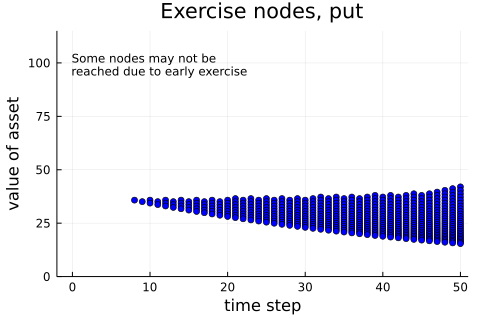

In [16]:
p1 = plot( xlim = (-2,n+1),
           ylim = (0,115),
           legend = false,
           title = "Exercise nodes, put",
           xlabel = "time step",
           ylabel = "value of asset",
           annotation = (0,100,text("Some nodes may not be\nreached due to early exercise",8,:left)) )

for i = 0:n, j = 1:length(STree[i])
    if Exerc[i][j]
        scatter!([i],[STree[i][j]],markercolor=:blue) 
    end
end
display(p1)

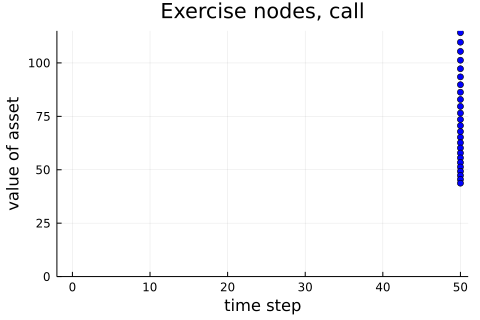

In [17]:
p1 = plot( xlim = (-2,n+1),
           ylim = (0,115),
           legend = false,
           title = "Exercise nodes, call",
           xlabel = "time step",
           ylabel = "value of asset")

for i = 0:n, j = 1:length(STree[i])
    if ExercC[i][j]
        scatter!([i],[STree[i][j]],markercolor=:blue) 
    end
end
display(p1)